Here I use blastn to identify the excision for simple cases.
This could have been integrated to the main code.
Here, I just identify the locus matching IS-flanking sequences in the genome of previous time-point.
The analysis is done in the next ipynb by checking whether the pair of flanks were adjacent to each other in the previous time-point.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import sys
import os
import glob
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
sys.path.append('../src/SyRI_IS/')
import importlib, subprocess
import run_utils

Procedure
- create dir: simple_excision analysis
- create flank files of G1, G2
- run blast against db of the next generation
- filter matches
- extract all match pairs that are connected by max 20 bp gap

In [2]:
file_df = pd.read_csv('../fasta/File_list_20240703.csv', na_filter=False) 
file_df.head()

,IS_Detect_ID,ParentLine,SubLine,gen,file_name,Anc,RecA,Prefix,sample_name_raw,Contig_Date,Complete,Folder,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,,0,0,Anc,20230904/MDS42_IS1.fa,,1,,,,,,,,,
1,L01_Anc,1,1,FACS,20231004/L01_Anc_m1.fasta,R01,1,L01-1,L01_Anc,20220418,TRUE,20231004,,,,1
2,L01_Anc,1,2,FACS,20231004/L01_Anc_m1.fasta,R01,1,L01-2,L01_Anc,20220418,TRUE,20231004,,,,2
3,L01_Anc,1,3,FACS,20231004/L01_Anc_m1.fasta,R01,1,L01-3,L01_Anc,20220418,TRUE,20231004,,,,3
4,L01_Anc,1,4,FACS,20231004/L01_Anc_m1.fasta,R01,1,L01-4,L01_Anc,20220418,TRUE,20231004,,,,4


In [3]:
file_df.gen

0       Anc
1      FACS
2      FACS
3      FACS
4      FACS
       ... 
128      20
129      20
130      20
131      20
132      20
Name: gen, Length: 133, dtype: object

In [4]:
# Base dirs (as in 20231004_multiple_runs)
master_dir = 'exp/multiple_runs11'
#is_detect_dir = 'exp/is_detect10'
tmpdir = os.path.join(master_dir, 'tmp')
exportdir = os.path.join(master_dir, 'export')
logdir = os.path.join(master_dir, 'log')
stderr_out = os.path.join(logdir, 'stderr_out')
os.makedirs(stderr_out, exist_ok=True)
fastadir = '../fasta/'
lines = file_df.Prefix.unique()
lines = [line for line in lines if line != '']
is_fasta = os.path.join(fastadir, 'IS1.fasta')
print(lines[0:5], len(lines))
os.makedirs(logdir, exist_ok=True)

['L01-1', 'L01-2', 'L01-3', 'L01-4', 'L02-1'] 44


In [5]:
#is_positions.to_csv(os.path.join(exportdir, 'classify_IS_events', 'IS_positions.csv'), index=False)
is_positions = pd.read_csv(os.path.join(exportdir, 'classify_IS_events', 'IS_positions.csv'))
is_positions.head()

,start,end,IS_strand,max_alignment_length,length,cluster_id,Line,Gen
0,476928,480020,reverse,3093,3093,0,L01-1,1
1,557167,560259,reverse,3093,3093,1,L01-1,1
2,1187831,1192502,forward,3093,4672,2,L01-1,1
3,1405123,1408215,forward,3093,3093,3,L01-1,1
4,1499230,1503892,reverse,3093,4663,4,L01-1,1


## With flank size 100 ( not used)
First test what happens when we use 100 bp of sequences flanking each IS and test whether the pair of flanking seqeunces were next to each other in the next generation.

### test with L01-1 G2

In [6]:
line_ = 'L01-1'
gen_ = 2
flank_size = 100 # 100 bp
os.makedirs(os.path.join(tmpdir, line_, 'simple_excision'), exist_ok=True)

# prepare the fasta file of flanks
is_positions_ = is_positions[(is_positions.Line == line_) & (is_positions.Gen == gen_)]
ref_fasta = SeqIO.read(os.path.join(tmpdir, line_, f'{line_}_genome.{gen_}.fasta'), 'fasta').seq

# Create DF Line Gen is_cluster_id head read_name
flank_df_v = []
flank_seqs = []
for i, row in is_positions_.iterrows():
	read_name_base = f'{line_}.{gen_}.{row.cluster_id}'
	read_name_ = f'{read_name_base}.head'
	flank_df_v.append({'Line': line_, 'Gen': gen_, 'is_cluster_id': row.cluster_id, 'head': 'head', 'read_name': read_name_})
	flank_seqs.append(SeqRecord(ref_fasta[(row.start - flank_size+1):row.start], id=read_name_, description=''))

	read_name_ = f'{read_name_base}.tail'
	flank_df_v.append({'Line': line_, 'Gen': gen_, 'is_cluster_id': row.cluster_id, 'head': 'tail', 'read_name': read_name_})
	flank_seqs.append(SeqRecord(ref_fasta[(row.end+2):(row.end+flank_size+1)], id=read_name_, description=''))
flank_fasta = os.path.join(tmpdir, line_, 'simple_excision', f'{line_}.{gen_}.flanks.fasta')
SeqIO.write(flank_seqs, flank_fasta, 'fasta')
flank_df = pd.DataFrame(flank_df_v)
flank_df.head()

,Line,Gen,is_cluster_id,head,read_name
0,L01-1,2,0,head,L01-1.2.0.head
1,L01-1,2,0,tail,L01-1.2.0.tail
2,L01-1,2,1,head,L01-1.2.1.head
3,L01-1,2,1,tail,L01-1.2.1.tail
4,L01-1,2,2,head,L01-1.2.2.head


In [7]:
#blastn_out_ = os.path.join(analysis_dir, 'annotation_of_variants.blastn')
#C = 'blastn -task blastn -query ' + os.path.join('../../test/refs/IS1_internal.fasta') + ' -evalue 1e-5 -db ' + dbdir
#C += ' -outfmt "7 sseqid qseqid qstart qend sstart send length evalue bitscore pident " -out '
#C += blastn_out_
dbdir = os.path.join(tmpdir, line_, 'blastdb', f'{line_}_genome.{gen_+1}.fasta')
#target_fasta = os.path.join(tmpdir, line_, 'simple_excision', f'{line_}.{gen_+1}.flanks.fasta')
blastn_out_ = os.path.join(tmpdir, line_, 'simple_excision', f'{line_}.{gen_}.blastn')
C = 'blastn -task blastn -query ' + flank_fasta + ' -evalue 1e-10 -db ' + dbdir
C += ' -outfmt "7 sseqid qseqid qstart qend sstart send length evalue bitscore pident " -out '
C += blastn_out_
!{C}

blast_df_ = pd.read_csv(blastn_out_, sep='\t', comment='#', header=None)
blast_df_.columns = ['sseqid', 'qseqid', 'qstart', 'qend', 'sstart', 'send', 'length', 'evalue', 'bitscore', 'pident']
blast_df_.head()

,sseqid,qseqid,qstart,qend,sstart,send,length,evalue,bitscore,pident
0,contig_1,L01-1.2.0.head,1,99,476827,476924,99,1.170000e-43,171,98.99
1,contig_1,L01-1.2.0.tail,1,99,480019,480117,99,2.260000e-46,179,100.00
2,contig_1,L01-1.2.1.tail,1,99,555159,555257,99,2.260000e-46,179,100.00
3,contig_1,L01-1.2.2.head,1,99,705960,706058,99,2.260000e-46,179,100.00
4,contig_1,L01-1.2.2.tail,1,99,709153,709251,99,2.260000e-46,179,100.00


### All data (with 300 bp)
Now lets do it with all data

In [8]:
flank_size = 300 # 300 bp

excision_flank_df_v = []
blast_df_v = []
for line_ in lines:
	for gen_ in [1,2]:
		os.makedirs(os.path.join(tmpdir, line_, 'simple_excision'), exist_ok=True)

		# prepare the fasta file of flanks
		is_positions_ = is_positions[(is_positions.Line == line_) & (is_positions.Gen == gen_)]
		ref_fasta = SeqIO.read(os.path.join(tmpdir, line_, f'{line_}_genome.{gen_}.fasta'), 'fasta').seq

		# Create DF Line Gen is_cluster_id head read_name
		flank_df_v = []
		flank_seqs = []
		for i, row in is_positions_.iterrows():
			read_name_base = f'{line_}.{gen_}.{row.cluster_id}'
			read_name_ = f'{read_name_base}.dir'
			flank_df_v.append({'Line': line_, 'Gen': gen_, 'is_cluster_id': row.cluster_id, 'dir': 'head', 'read_name': read_name_})
			flank_seqs.append(SeqRecord(ref_fasta[(row.start - flank_size+1):row.start], id=read_name_, description=''))

			read_name_ = f'{read_name_base}.tail'
			flank_df_v.append({'Line': line_, 'Gen': gen_, 'is_cluster_id': row.cluster_id, 'dir': 'tail', 'read_name': read_name_})
			flank_seqs.append(SeqRecord(ref_fasta[(row.end+2):(row.end+flank_size+1)], id=read_name_, description=''))
		flank_fasta = os.path.join(tmpdir, line_, 'simple_excision', f'{line_}.{gen_}.flanks.fasta')
		SeqIO.write(flank_seqs, flank_fasta, 'fasta')
		flank_df = pd.DataFrame(flank_df_v)

		# blastn
		dbdir = os.path.join(tmpdir, line_, 'blastdb', f'{line_}_genome.{gen_+1}.fasta')

		blastn_out_ = os.path.join(tmpdir, line_, 'simple_excision', f'{line_}.{gen_}.blastn')
		C = 'blastn -task blastn -query ' + flank_fasta + ' -evalue 1e-10 -db ' + dbdir
		C += ' -outfmt "7 sseqid qseqid qstart qend sstart send length evalue bitscore pident " -out '
		C += blastn_out_
		!{C}

		blast_df_ = pd.read_csv(blastn_out_, sep='\t', comment='#', header=None)
		blast_df_.columns = ['sseqid', 'qseqid', 'qstart', 'qend', 'sstart', 'send', 'length', 'evalue', 'bitscore', 'pident']

		# save results
		blast_df_.to_csv(os.path.join(tmpdir, line_, 'simple_excision', f'{line_}.{gen_}.blastn.csv'), index=False)
		excision_flank_df_v.append(flank_df)
		blast_df_v.append(blast_df_)
excision_flank_df = pd.concat(excision_flank_df_v)
blast_df = pd.concat(blast_df_v)

In [9]:
excision_flank_df

,Line,Gen,is_cluster_id,dir,read_name
0,L01-1,1,0,head,L01-1.1.0.dir
1,L01-1,1,0,tail,L01-1.1.0.tail
2,L01-1,1,1,head,L01-1.1.1.dir
3,L01-1,1,1,tail,L01-1.1.1.tail
4,L01-1,1,2,head,L01-1.1.2.dir
...,...,...,...,...,...
39,L11-4,2,19,tail,L11-4.2.19.tail
40,L11-4,2,20,head,L11-4.2.20.dir
41,L11-4,2,20,tail,L11-4.2.20.tail
42,L11-4,2,21,head,L11-4.2.21.dir


In [10]:
blast_df

,sseqid,qseqid,qstart,qend,sstart,send,length,evalue,bitscore,pident
0,L01-1_genome.2_m,L01-1.1.0.dir,1,299,476607,476905,299,2.190000e-154,540.0,100.000
1,L01-1_genome.2_m,L01-1.1.0.tail,1,299,479999,480297,299,2.190000e-154,540.0,100.000
2,L01-1_genome.2_m,L01-1.1.2.dir,1,298,1185656,1185953,298,7.630000e-154,538.0,100.000
3,L01-1_genome.2_m,L01-1.1.2.tail,2,299,1203686,1203389,298,7.630000e-154,538.0,100.000
4,L01-1_genome.2_m,L01-1.1.2.tail,1,222,1086662,1086441,222,7.190000e-15,77.0,67.568
...,...,...,...,...,...,...,...,...,...,...
48,"edge_1+,edge_3-,edge_2-,edge_3_copy+(circular)",L11-4.2.19.dir,1,299,3675131,3675429,299,2.310000e-154,540.0,100.000
49,"edge_1+,edge_3-,edge_2-,edge_3_copy+(circular)",L11-4.2.19.tail,1,299,3678523,3678821,299,2.310000e-154,540.0,100.000
50,"edge_1+,edge_3-,edge_2-,edge_3_copy+(circular)",L11-4.2.20.dir,1,299,4161944,4162242,299,2.310000e-154,540.0,100.000
51,"edge_1+,edge_3-,edge_2-,edge_3_copy+(circular)",L11-4.2.20.tail,1,299,4165336,4165634,299,2.310000e-154,540.0,100.000


#### raw output

In [11]:
# For each IS (enumerated as is_cluster_id), the names of the flanking sequences are in col: read_name
# sseqid: name of the sequence in the fasta file, length: length of match
merged_df = pd.merge(excision_flank_df, blast_df,
	left_on = 'read_name', right_on = 'qseqid', how='inner').drop('qseqid', axis=1).reset_index(drop=True)
merged_df.to_csv(os.path.join(exportdir, 'classify_IS_events', 'excision_flank_blast.csv'), index=False)
merged_df.head()

,Line,Gen,is_cluster_id,dir,read_name,sseqid,qstart,qend,sstart,send,length,evalue,bitscore,pident
0,L01-1,1,0,head,L01-1.1.0.dir,L01-1_genome.2_m,1,299,476607,476905,299,2.190000e-154,540.0,100.000
1,L01-1,1,0,tail,L01-1.1.0.tail,L01-1_genome.2_m,1,299,479999,480297,299,2.190000e-154,540.0,100.000
2,L01-1,1,2,head,L01-1.1.2.dir,L01-1_genome.2_m,1,298,1185656,1185953,298,7.630000e-154,538.0,100.000
3,L01-1,1,2,tail,L01-1.1.2.tail,L01-1_genome.2_m,2,299,1203686,1203389,298,7.630000e-154,538.0,100.000
4,L01-1,1,2,tail,L01-1.1.2.tail,L01-1_genome.2_m,1,222,1086662,1086441,222,7.190000e-15,77.0,67.568


### get the distance between in the previous generation 

In [12]:
# test code with L01-1 gen 2
line_ = 'L01-1'
gen_ = 2

merged_df_ = merged_df[(merged_df.Line == line_) & (merged_df.Gen == gen_)]
valid_df_v = []
for is_cluster_id in merged_df_.is_cluster_id.unique():
	merged_df__ = merged_df_[merged_df_.is_cluster_id == is_cluster_id]
	min_dist = int(1e8) # if no valid pair is found
	min_i = -1
	min_j = -1
	min_start = -1
	min_end = -1
	for i, rowh in merged_df__[merged_df__.dir == 'head'].iterrows():
		for j, rowt in merged_df__[merged_df__.dir == 'tail'].iterrows():
			start_ = rowh.send - (99 - rowh.qend)
			end_ = rowt.sstart + (rowt.qstart - 99)
			dist_ = end_ - start_ - 1
			#print(start_, end_, dist_)
			if dist_ < min_dist:
				min_dist = dist_
				min_start = start_
				min_end = end_
				min_i = i
				min_j = j
	valid_df_v.append({'Line': line_, 'Gen': gen_, 'is_cluster_id': is_cluster_id, 'min_dist': min_dist, 'min_start': min_start, 'min_end': min_end, 'min_i': min_i, 'min_j': min_j})
valid_df = pd.DataFrame(valid_df_v)
valid_df.head()

,Line,Gen,is_cluster_id,min_dist,min_start,min_end,min_i,min_j
0,L01-1,2,0,2796,477124,479921,22,23
1,L01-1,2,1,100000000,-1,-1,-1,-1
2,L01-1,2,2,2796,706258,709055,25,26
3,L01-1,2,3,203963,1188820,1392784,27,28
4,L01-1,2,4,-3393,1380021,1376629,29,31


In [13]:
valid_df_v = []
for line_ in lines:
	for gen_ in [1,2]:
		merged_df_ = merged_df[(merged_df.Line == line_) & (merged_df.Gen == gen_)]
		for is_cluster_id in merged_df_.is_cluster_id.unique():
			merged_df__ = merged_df_[merged_df_.is_cluster_id == is_cluster_id]
			min_dist = int(1e8)
			min_i = -1
			min_j = -1
			min_start = -1
			min_end = -1
			for i, rowh in merged_df__[merged_df__.dir == 'head'].iterrows():
				for j, rowt in merged_df__[merged_df__.dir == 'tail'].iterrows():
					start_ = rowh.send - (299 - rowh.qend)
					end_ = rowt.sstart + (rowt.qstart)
					dist_ = abs(end_ - start_ - 1)
					#print(start_, end_, dist_)
					if dist_ < min_dist:
						min_dist = dist_
						min_start = start_
						min_end = end_
						min_i = i
						min_j = j
			valid_df_v.append({'Line': line_, 'Gen': gen_, 'is_cluster_id': is_cluster_id, 'min_dist': min_dist, 'min_start': min_start, 'min_end': min_end, 'min_i': min_i, 'min_j': min_j})
valid_df = pd.DataFrame(valid_df_v)
valid_df.head()

,Line,Gen,is_cluster_id,min_dist,min_start,min_end,min_i,min_j
0,L01-1,1,0,3094,476905,480000,0,1
1,L01-1,1,2,17735,1185952,1203688,2,3
2,L01-1,1,3,3094,1406354,1409449,5,6
3,L01-1,1,4,4664,1500452,1505117,7,8
4,L01-1,1,5,4665,1993862,1998528,9,10


<Axes: >

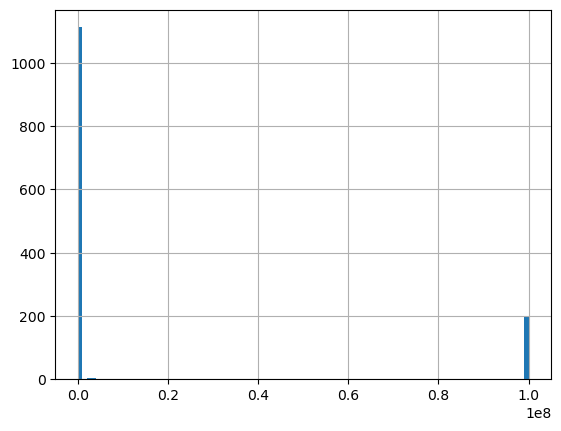

In [14]:
# most of the distances should be 0 (perfect excision) or 3000 (no excision, IS still present)
valid_df['min_dist'].hist(bins=100) 

In [16]:
# examples
merged_df[(merged_df.Line == 'L01-4') & (merged_df.Gen == 2) & (merged_df.is_cluster_id == 10)]

,Line,Gen,is_cluster_id,dir,read_name,sseqid,qstart,qend,sstart,send,length,evalue,bitscore,pident
267,L01-4,2,10,head,L01-4.2.10.dir,contig_1,1,299,2461813,2462111,299,2.180000e-154,540.0,100.000
268,L01-4,2,10,head,L01-4.2.10.dir,contig_1,133,227,3612073,3611980,97,1.140000e-18,90.6,83.505
269,L01-4,2,10,head,L01-4.2.10.dir,contig_1,242,298,2468346,2468402,57,5.890000e-16,81.5,91.228
270,L01-4,2,10,head,L01-4.2.10.dir,contig_1,133,225,3102314,3102216,103,7.180000e-15,77.9,79.612
271,L01-4,2,10,head,L01-4.2.10.dir,contig_1,133,224,1390245,1390342,101,7.180000e-15,77.0,79.208
272,L01-4,2,10,head,L01-4.2.10.dir,contig_1,133,227,3728080,3728181,105,2.510000e-14,76.1,79.048
273,L01-4,2,10,head,L01-4.2.10.dir,contig_1,133,225,2843384,2843286,102,8.750000e-14,74.3,78.431
274,L01-4,2,10,head,L01-4.2.10.dir,contig_1,132,228,1360297,1360193,108,8.750000e-14,73.4,77.778
275,L01-4,2,10,head,L01-4.2.10.dir,contig_1,132,227,1492617,1492719,106,8.750000e-14,73.4,78.302
276,L01-4,2,10,head,L01-4.2.10.dir,contig_1,133,225,1373540,1373639,103,3.050000e-13,72.5,78.641


In [17]:
merged_df[(merged_df.Line == 'L10-4') & (merged_df.Gen == 2) & (merged_df.is_cluster_id == 10)]

,Line,Gen,is_cluster_id,dir,read_name,sseqid,qstart,qend,sstart,send,length,evalue,bitscore,pident
2602,L10-4,2,10,head,L10-4.2.10.dir,contig_1,1,299,2803283,2803581,299,2.220000e-154,540.0,100.000
2603,L10-4,2,10,head,L10-4.2.10.dir,contig_1,6,294,3266254,3265966,289,5.980000e-54,206.0,75.779
2604,L10-4,2,10,tail,L10-4.2.10.tail,contig_1,1,299,2806676,2806974,299,2.220000e-154,540.0,100.000
2605,L10-4,2,10,tail,L10-4.2.10.tail,contig_1,6,299,3265963,3265670,294,8.310000e-46,179.0,73.469


In [18]:
merged_df[(merged_df.Line == 'L03-3') & (merged_df.Gen == 2) & (merged_df.is_cluster_id == 9)]

,Line,Gen,is_cluster_id,dir,read_name,sseqid,qstart,qend,sstart,send,length,evalue,bitscore,pident
787,L03-3,2,9,head,L03-3.2.9.dir,contig_1,1,299,1894460,1894162,299,2.130000e-154,540.0,100.0
788,L03-3,2,9,tail,L03-3.2.9.tail,contig_1,1,299,1894165,1894463,299,2.130000e-154,540.0,100.0


In [19]:
merged_df[(merged_df.Line == 'L08-4') & (merged_df.Gen == 2) & (merged_df.is_cluster_id == 1)]

,Line,Gen,is_cluster_id,dir,read_name,sseqid,qstart,qend,sstart,send,length,evalue,bitscore,pident
2124,L08-4,2,1,head,L08-4.2.1.dir,contig_1,1,298,69183,69480,298,7.590000e-154,538.0,100.0
2125,L08-4,2,1,tail,L08-4.2.1.tail,contig_1,1,299,69474,69772,299,2.170000e-154,540.0,100.0


In [20]:
valid_df[(valid_df.Line == 'L08-4') & (valid_df.Gen == 2)]

,Line,Gen,is_cluster_id,min_dist,min_start,min_end,min_i,min_j
982,L08-4,2,0,3095,33488,36584,2121,2122
983,L08-4,2,1,5,69479,69475,2124,2125
984,L08-4,2,2,3094,852784,855879,2126,2127
985,L08-4,2,3,3094,1073666,1076761,2128,2129
986,L08-4,2,4,3094,1282608,1285703,2130,2131
987,L08-4,2,5,3095,1305663,1308759,2132,2133
988,L08-4,2,6,3095,1857465,1860561,2134,2135
989,L08-4,2,7,3093,2119754,2122848,2136,2137
990,L08-4,2,8,3095,2148319,2151415,2138,2139
991,L08-4,2,9,3095,2349827,2352923,2140,2141


In [21]:
valid_df_v = []
for line_ in lines:
	for gen_ in [1,2]:
		merged_df_ = merged_df[(merged_df.Line == line_) & (merged_df.Gen == gen_)]
		for is_cluster_id in merged_df_.is_cluster_id.unique():
			merged_df__ = merged_df_[merged_df_.is_cluster_id == is_cluster_id]
			min_dist = int(1e8)
			if len(merged_df__.dir.unique()) == 2:
				min_i = merged_df__[merged_df__.dir == 'head']['evalue'].idxmin()
				min_j = merged_df__[merged_df__.dir == 'tail']['evalue'].idxmin()
				min_start = merged_df.iloc[min_i].send - (299 - merged_df.iloc[min_i].qend)
				min_end = merged_df.iloc[min_j].sstart + (merged_df.iloc[min_j].qstart)
				min_start_raw = merged_df.iloc[min_i].send 
				min_end_raw = merged_df.iloc[min_j].sstart
				flank_dist =  - merged_df.iloc[min_i].send + merged_df.iloc[min_j].sstart
				raw_dist_ = min_end - min_start - 1
				dist_ = abs(raw_dist_)
				dir = (merged_df.iloc[min_i].send - merged_df.iloc[min_i].sstart) * (merged_df.iloc[min_j].send - merged_df.iloc[min_j].sstart) > 0
				if dist_ < min_dist:
					min_dist = dist_
				valid_df_v.append({'Line': line_, 'Gen': gen_, 'is_cluster_id': is_cluster_id,
				'min_dist': min_dist, 'min_start': min_start, 'min_end': min_end,
				'min_i': min_i, 'min_j': min_j, 'raw_dist': raw_dist_,
				'min_start_raw': min_start_raw, 'min_end_raw': min_end_raw, 'flank_dist': flank_dist,
				'dir': dir})
valid_df = pd.DataFrame(valid_df_v)
valid_df.head()

,Line,Gen,is_cluster_id,min_dist,min_start,min_end,min_i,min_j,raw_dist,min_start_raw,min_end_raw,flank_dist,dir
0,L01-1,1,0,3094,476905,480000,0,1,3094,476905,479999,3094,True
1,L01-1,1,2,17735,1185952,1203688,2,3,17735,1185953,1203686,17733,False
2,L01-1,1,3,3094,1406354,1409449,5,6,3094,1406354,1409448,3094,True
3,L01-1,1,4,4664,1500452,1505117,7,8,4664,1500452,1505116,4664,True
4,L01-1,1,5,4665,1993862,1998528,9,10,4665,1993862,1998527,4665,True


<Axes: >

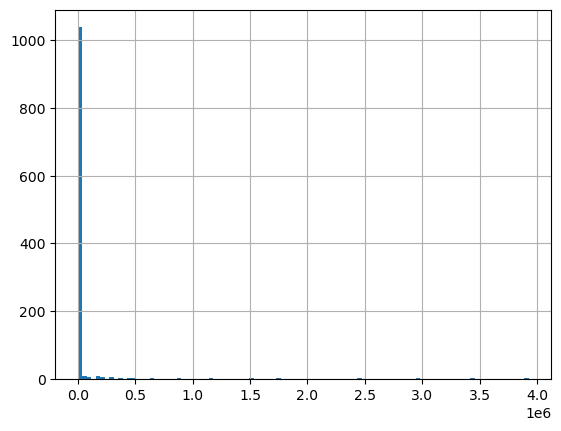

In [22]:
valid_df['min_dist'].hist(bins=100)

<Axes: >

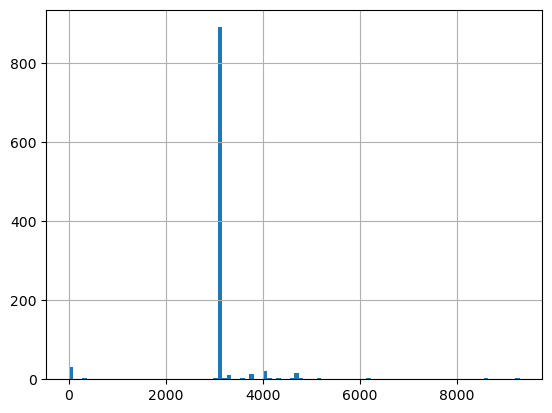

In [23]:
valid_df[valid_df.min_dist < 10000]['min_dist'].hist(bins=100)

3-3 is false likely because it seems to include an IS nearby.
It seems to be a false positive; its not excised but rather deleted by two ISs nearby.
7-1-4 is also false positive; it is likely lost in the ancestor.

In [24]:
valid_df[valid_df.min_dist < 2000]

,Line,Gen,is_cluster_id,min_dist,min_start,min_end,min_i,min_j,raw_dist,min_start_raw,min_end_raw,flank_dist,dir
62,L01-3,2,10,5,1932253,1932249,202,203,-5,1932254,1932248,-6,True
71,L01-4,1,1,5,557154,557150,223,224,-5,557155,557149,-6,True
101,L02-1,1,8,370,3353267,3352898,330,331,-370,3353267,3352775,-492,True
112,L02-1,2,7,5,2097938,2097934,361,362,-5,2097939,2097933,-6,True
149,L02-2,2,15,614,3767832,3768447,460,461,614,3767832,3768324,492,True
164,L02-3,1,8,370,3360625,3360256,498,499,-370,3360625,3360133,-492,True
174,L02-3,2,4,5,1305531,1305527,522,523,-5,1305532,1305526,-6,True
209,L02-4,2,7,4,2173357,2173354,609,610,-4,2173358,2173353,-5,True
220,L02-4,2,20,6,3667801,3667796,639,640,-6,3667801,3667795,-6,True
283,L03-3,2,6,5,1617302,1617298,781,782,-5,1617303,1617297,-6,True


# With 3000 bp flanks used in the next ipynb

In [25]:
merged_df300 = merged_df.copy()
valid_df300 = valid_df.copy()

In [26]:
flank_size = 3000 # 3000 bp

excision_flank_df_v = []
blast_df_v = []
for line_ in lines:
	for gen_ in [1,2]:
		os.makedirs(os.path.join(tmpdir, line_, 'simple_excision'), exist_ok=True)

		# prepare the fasta file of flanks
		is_positions_ = is_positions[(is_positions.Line == line_) & (is_positions.Gen == gen_)]
		ref_fasta = SeqIO.read(os.path.join(tmpdir, line_, f'{line_}_genome.{gen_}.fasta'), 'fasta').seq

		# Create DF Line Gen is_cluster_id head read_name
		flank_df_v = []
		flank_seqs = []
		for i, row in is_positions_.iterrows():
			read_name_base = f'{line_}.{gen_}.{row.cluster_id}'
			read_name_ = f'{read_name_base}.dir'
			flank_df_v.append({'Line': line_, 'Gen': gen_, 'is_cluster_id': row.cluster_id, 'dir': 'head', 'read_name': read_name_})
			flank_seqs.append(SeqRecord(ref_fasta[(row.start - flank_size+1):row.start], id=read_name_, description=''))

			read_name_ = f'{read_name_base}.tail'
			flank_df_v.append({'Line': line_, 'Gen': gen_, 'is_cluster_id': row.cluster_id, 'dir': 'tail', 'read_name': read_name_})
			flank_seqs.append(SeqRecord(ref_fasta[(row.end+2):(row.end+flank_size+1)], id=read_name_, description=''))
		######### NEW Flank #########
		flank_fasta = os.path.join(tmpdir, line_, 'simple_excision', f'{line_}.{gen_}.flanks.3000.fasta')
		SeqIO.write(flank_seqs, flank_fasta, 'fasta')
		flank_df = pd.DataFrame(flank_df_v)

		# blastn
		dbdir = os.path.join(tmpdir, line_, 'blastdb', f'{line_}_genome.{gen_+1}.fasta')

		blastn_out_ = os.path.join(tmpdir, line_, 'simple_excision', f'{line_}.{gen_}.blastn')
		C = 'blastn -task blastn -query ' + flank_fasta + ' -evalue 1e-10 -db ' + dbdir
		C += ' -outfmt "7 sseqid qseqid qstart qend sstart send length evalue bitscore pident " -out '
		C += blastn_out_
		!{C}

		blast_df_ = pd.read_csv(blastn_out_, sep='\t', comment='#', header=None)
		blast_df_.columns = ['sseqid', 'qseqid', 'qstart', 'qend', 'sstart', 'send', 'length', 'evalue', 'bitscore', 'pident']

		# save results
		######### NEW Flank #########
		blast_df_.to_csv(os.path.join(tmpdir, line_, 'simple_excision', f'{line_}.{gen_}.blastn.3000.csv'), index=False)
		excision_flank_df_v.append(flank_df)
		blast_df_v.append(blast_df_)
excision_flank_df = pd.concat(excision_flank_df_v)
blast_df = pd.concat(blast_df_v)

merged_df = pd.merge(excision_flank_df, blast_df,
	left_on = 'read_name', right_on = 'qseqid', how='inner').drop('qseqid', axis=1).reset_index(drop=True)
merged_df.to_csv(os.path.join(exportdir, 'classify_IS_events', 'excision_flank_blast.3000.csv'), index=False) # save matched flanks
merged_df.head()

,Line,Gen,is_cluster_id,dir,read_name,sseqid,qstart,qend,sstart,send,length,evalue,bitscore,pident
0,L01-1,1,0,head,L01-1.1.0.dir,L01-1_genome.2_m,1,2999,473907,476905,2999,0.000000e+00,5409.0,100.000
1,L01-1,1,0,tail,L01-1.1.0.tail,L01-1_genome.2_m,1,2999,479999,482997,2999,0.000000e+00,5409.0,100.000
2,L01-1,1,1,head,L01-1.1.1.dir,L01-1_genome.2_m,1974,2063,547666,547577,90,1.820000e-15,82.4,80.000
3,L01-1,1,1,tail,L01-1.1.1.tail,L01-1_genome.2_m,311,2999,555600,558289,2690,0.000000e+00,4844.0,99.963
4,L01-1,1,2,head,L01-1.1.2.dir,L01-1_genome.2_m,1,2998,1182956,1185953,2998,0.000000e+00,5407.0,100.000


In [27]:
valid_df_v = [] # find simple excision events
for line_ in lines:
	for gen_ in [1,2]:
		merged_df_ = merged_df[(merged_df.Line == line_) & (merged_df.Gen == gen_)]
		for is_cluster_id in merged_df_.is_cluster_id.unique(): # for each IS in the predecessor
			merged_df__ = merged_df_[merged_df_.is_cluster_id == is_cluster_id]
			min_dist = int(1e8)
			if len(merged_df__.dir.unique()) == 2:
				min_i = merged_df__[merged_df__.dir == 'head']['evalue'].idxmin()
				min_j = merged_df__[merged_df__.dir == 'tail']['evalue'].idxmin()
				# start position of flanks based on estimating deleted regions of flank
				min_start = merged_df.iloc[min_i].send - (flank_size-1 - merged_df.iloc[min_i].qend)
				min_end = merged_df.iloc[min_j].sstart + (merged_df.iloc[min_j].qstart)
				# start position of flanks based directly on blastn
				min_start_raw = merged_df.iloc[min_i].send 
				min_end_raw = merged_df.iloc[min_j].sstart
				flank_dist = - merged_df.iloc[min_i].send + merged_df.iloc[min_j].sstart -1 if merged_df.iloc[min_i].send > merged_df.iloc[min_i].sstart else merged_df.iloc[min_i].send - merged_df.iloc[min_j].sstart -1
				raw_dist_ = min_end - min_start - 1
				dist_ = abs(flank_dist) # changed from raw_dist_ to flank_dist
				dir = (merged_df.iloc[min_i].send - merged_df.iloc[min_i].sstart) * (merged_df.iloc[min_j].send - merged_df.iloc[min_j].sstart) > 0
				if dist_ < min_dist:
					min_dist = dist_
				valid_df_v.append({'Line': line_, 'Gen': gen_, 'is_cluster_id': is_cluster_id,
				'min_dist': min_dist,
				'head_qend': merged_df.iloc[min_i].qend, 'tail_qstart': merged_df.iloc[min_j].qstart,
				'min_i': min_i, 'min_j': min_j, 'raw_dist': raw_dist_,
				'min_start_raw': min_start_raw, 'min_end_raw': min_end_raw, 'flank_dist': flank_dist,
				'dir': dir}) # get the minimal distances in the ancestor
valid_df = pd.DataFrame(valid_df_v)
valid_df.head()

,Line,Gen,is_cluster_id,min_dist,head_qend,tail_qstart,min_i,min_j,raw_dist,min_start_raw,min_end_raw,flank_dist,dir
0,L01-1,1,0,3093,2999,1,0,1,3094,476905,479999,3093,True
1,L01-1,1,1,8024,2063,311,2,3,9269,547577,555600,-8024,False
2,L01-1,1,2,17732,2998,2,4,9,17735,1185953,1203686,17732,False
3,L01-1,1,3,3093,2999,1,11,12,3094,1406354,1409448,3093,True
4,L01-1,1,4,4663,2999,1,15,16,4664,1500452,1505116,4663,True


<Axes: >

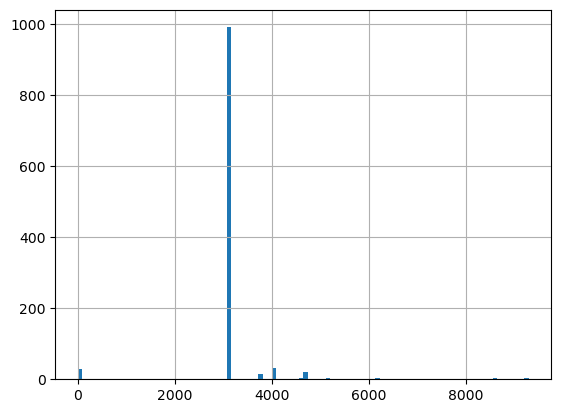

In [28]:
# mostly around 3000 bp ( size of IS) as expected
valid_df[valid_df.min_dist < 10000]['min_dist'].hist(bins=100)

In [30]:
# show an example
merged_df[(merged_df.Line == 'L05-2') & (merged_df.Gen == 2) & (merged_df.is_cluster_id == 5)]

,Line,Gen,is_cluster_id,dir,read_name,sseqid,qstart,qend,sstart,send,length,evalue,bitscore,pident
6322,L05-2,2,5,head,L05-2.2.5.dir,contig_1,1,2806,2981102,2978266,2837,0.0,4879.0,98.766
6323,L05-2,2,5,tail,L05-2.2.5.tail,contig_1,1,2999,2975170,2972172,2999,0.0,5409.0,100.000


In [31]:
# save the excisions
valid_df.to_csv(os.path.join(exportdir, 'classify_IS_events', 'excision_status.3000.csv'), index=False)